<a href="https://colab.research.google.com/github/NvkAnirudh/diffusion-models/blob/main/Diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0

In [34]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [35]:
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

def show_images(x):
    x = x*0.5 + 0.5
    grid = torchvision.utils.make_grid(x)
    grid_image = grid.detach().cpu().permute(1,2,0).clip(0,1)*255
    grid_image = Image.fromarray(np.array(grid_image).astype(np.uint8))
    return grid_image

def make_grid(images, size=64):
    output_image = Image.new("RGB", (size*len(images), size))
    for i,image in enumerate(images):
        output_image.paste(image.resize((size, size)), (i*size, 0))
    return output_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Stable Diffusion Pipeline (Mr Potato Head)

In [36]:
from diffusers import StableDiffusionPipeline

model_id = "sd-dreambooth-library/mr-potato-head"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

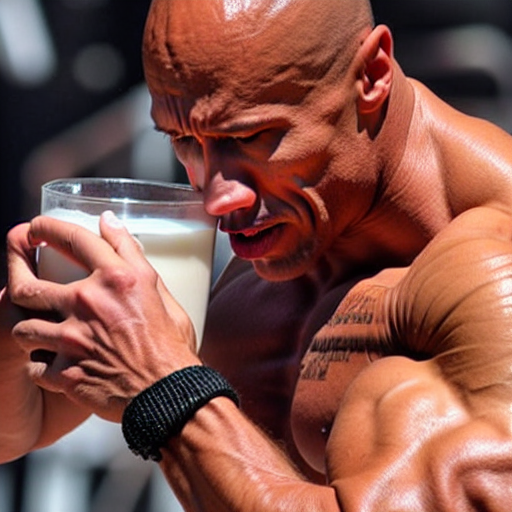

In [37]:
# prompt = "an abstract oil painting of sks mr potato head by picasso"
prompt = "the rock drinking milk"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
image

## Custom diffusers pipeline with hugging face's butterfly dataset

Downloading training dataset

In [38]:
import torchvision
from torchvision import transforms
from datasets import load_dataset

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

image_size = 32
batch_size = 64

# Defining data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(), #Random flip
        transforms.ToTensor(), #Convert to tensor (0,1)
        transforms.Normalize([0.5], [0.5]), #map to (-1, 1)
    ]
)

def transform(examples):
  images = [preprocess(image.convert("RGB")) for image in examples["image"]]
  return {"images": images}

dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

Sample shape: torch.Size([8, 3, 32, 32])


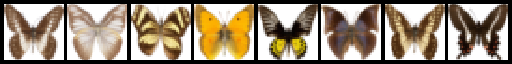

In [39]:
# Showing a batch of transformed images
samples = next(iter(train_dataloader))["images"].to(device)[:8]
print("Sample shape:", samples.shape)
show_images(samples).resize((8*64, 64), resample=Image.NEAREST)

Scheduler

In [40]:
# Using default noise scheduler (Denoising. Diffusion Probabalistic Models - DDPM) to add noises to the input images and using model predictions to iteratively remoce noise
from diffusers import DDPMScheduler

# noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Different types of schedulers with different beta_start, beta_end, and beta_schedulers
# Scheduler with little too noise
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)

# # Randome scheduler
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.1, beta_end=0.01)

# # Cosine scheduler which may be better for small image sizes
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

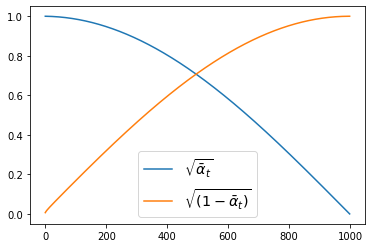

In [41]:
# Plotting sqrt_alpha_prod and sqrt_one_minus_alpha_prod
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

Noisy sample shape: torch.Size([8, 3, 32, 32])


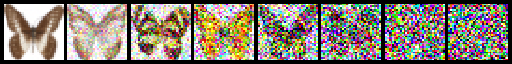

In [42]:
# Adding noise to the input images
timesteps = torch.linspace(0,999,8).long().to(device)
noise = torch.randn_like(samples) #Takes the same size as input (samples) and fills with random numbers from a normal distribution with mean 0 and variance 1
noisy_samples = noise_scheduler.add_noise(samples, noise, timesteps) #Adding noise to the input (samples)
print("Noisy sample shape:", noisy_samples.shape)
show_images(noisy_samples).resize((8*64, 64), resample=Image.NEAREST)

# Modeling (UNet architecture)

In [43]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size = image_size,
    in_channels = 3, # number of input channels, 3 for RGB
    out_channels = 3, # number of output channels, 3 for RGB
    layers_per_block = 2, #number of ResNet layers to use per UNet block
    block_out_channels = (64, 128, 128, 256),
    down_block_types = (
        "DownBlock2D", # Regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D", # ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D"
    ),
    up_block_types = (
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    ),
)

model.to(device);

In [44]:
# Passing a batch of data (noisy samples created above) along with some random timesteps to check the size of the output (if it is same as input)
with torch.no_grad(): # This function disables gradient calculation (doesn't perform backward calculation - no weights are updated)
  model_prediction = model(noisy_samples, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])

# Creating a training loop

1) Generating random noise 

2) Generating random timesteps

3) Adding noise to the clean images (input)

4) Making model predictions

5) Calculating loss between predicitons and actual noise

6) Updating the parameters (weights) using loss.backward() and optimizer.step()

7) Storing losses for later plot

In [45]:
# Noise scheduler to addn noise
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
  for step, batch in enumerate(train_dataloader):
    clean_images = batch["images"].to(device)

    # Sample random noise to add to the clean images
    noise = torch.randn(clean_images.shape).to(clean_images.device)
    bs = clean_images.shape[0]

    # Sample random timesteps
    timesteps = torch.randint(
        0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()
    
    # Adding noise to clean images
    noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

    # Getting the model predictions
    noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

    # Calculating the loss between the preds and actual loss
    loss = F.mse_loss(noise_pred, noise)
    loss.backward(loss)
    losses.append(loss.item())

    # Updating the model parameters
    optimizer.step()
    optimizer.zero_grad()

  if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")


Epoch:5, loss: 0.15308640990406275
Epoch:10, loss: 0.11715600499883294
Epoch:15, loss: 0.09132071072235703
Epoch:20, loss: 0.08722566394135356
Epoch:25, loss: 0.08095910190604627
Epoch:30, loss: 0.07518060645088553


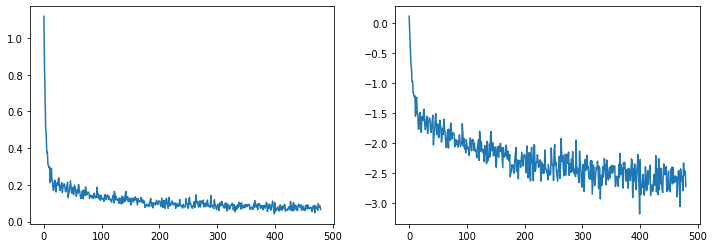

In [48]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

# Generating Images

  0%|          | 0/1000 [00:00<?, ?it/s]

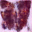

In [50]:
from diffusers import DDPMPipeline

image_pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)

pipeline_output = image_pipeline()
pipeline_output.images[0]

In [51]:
# Saving a pipeline to local folder
image_pipeline.save_pretrained("diffusers_pipeline")

In [52]:
!ls diffusers_pipeline/

model_index.json  scheduler  unet


In [53]:
!ls diffusers_pipeline/unet/

config.json  diffusion_pytorch_model.bin


# Sampling loop to generate images from most noisy image to least noisy image

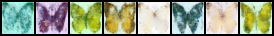

In [62]:
# 8 random images
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):
  # model pred
  with torch.no_grad(): 
    residual = model(sample, t).sample

  # Update sample with step
  sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

# Pushing model to Hugging Face hub

In [63]:
from huggingface_hub import get_full_repo_name

model_name = "sd-butterflies32"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'NvkAnirudh/sd-butterflies32'

In [64]:
from huggingface_hub import HfApi, create_repo

create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path = "diffusers_pipeline/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(
    folder_path = "diffusers_pipeline/unet", path_in_repo="", repo_id=hub_model_id
)
api.upload_file(
    path_or_fileobj="diffusers_pipeline/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)


diffusion_pytorch_model.bin:   0%|          | 0.00/74.3M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

'https://huggingface.co/NvkAnirudh/sd-butterflies32/blob/main/model_index.json'

In [65]:
from huggingface_hub import ModelCard

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for my first Diffusion Model which is for unconditional image generation of beautiful butterflies.

This model is trained on a dataset of butterflies of image size 32*32 

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

'https://huggingface.co/NvkAnirudh/sd-butterflies32/blob/main/README.md'

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

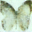

In [66]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline.from_pretrained(hub_model_id)
pipeline_output = image_pipe()
pipeline_output.images[0]